In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Solar_data.csv')

In [3]:
data.head()

,DATE_TIME,DAILY_YIELD,lag_1,lag_2,lag_DY,Month,Day,Hour,Minute,Weekday
0,2020/5/17 5:00,0.0,0.0,0.0,0.0,0,0.533333,0.217391,0.000000,1.0
1,2020/5/17 5:15,0.0,0.0,0.0,0.0,0,0.533333,0.217391,0.333333,1.0
2,2020/5/17 5:30,0.0,0.0,0.0,0.0,0,0.533333,0.217391,0.666667,1.0
3,2020/5/17 5:45,0.0,0.0,0.0,0.0,0,0.533333,0.217391,1.000000,1.0
4,2020/5/17 6:00,0.0,0.0,0.0,0.0,0,0.533333,0.260870,0.000000,1.0


In [4]:
train = data[:-192]
test = data[-192:]
print(train.shape)
print(test.shape)

(2734, 10)
(192, 10)


In [5]:
x_train = train.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_train = train.loc[:, ['DAILY_YIELD']]

x_test = test.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_test = test.loc[:, ['DAILY_YIELD']]

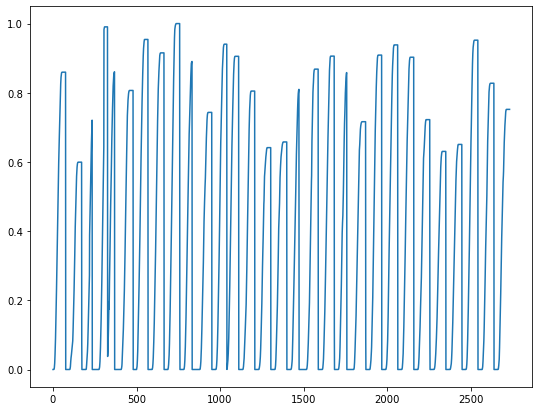

In [6]:
sns.reset_orig()
plt.figure(figsize = (9,7))
#plt.title('Solar Power', fontsize = 24)
plt.plot(y_train['DAILY_YIELD'], label = 'trainset')
#plt.plot(y_test['DAILY_YIELD'], label = 'testset')

#plt.legend(fontsize = 14)
plt.show()

# XGBoost

In [7]:
import xgboost

In [8]:
model = xgboost.XGBRegressor().fit(x_train, y_train)

pred = model.predict(x_test)
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)

print('R2: ', r2, '  ;  ', 'MSE: ', mse)

R2:  0.9307557231888863   ;   MSE:  0.005564452972474564


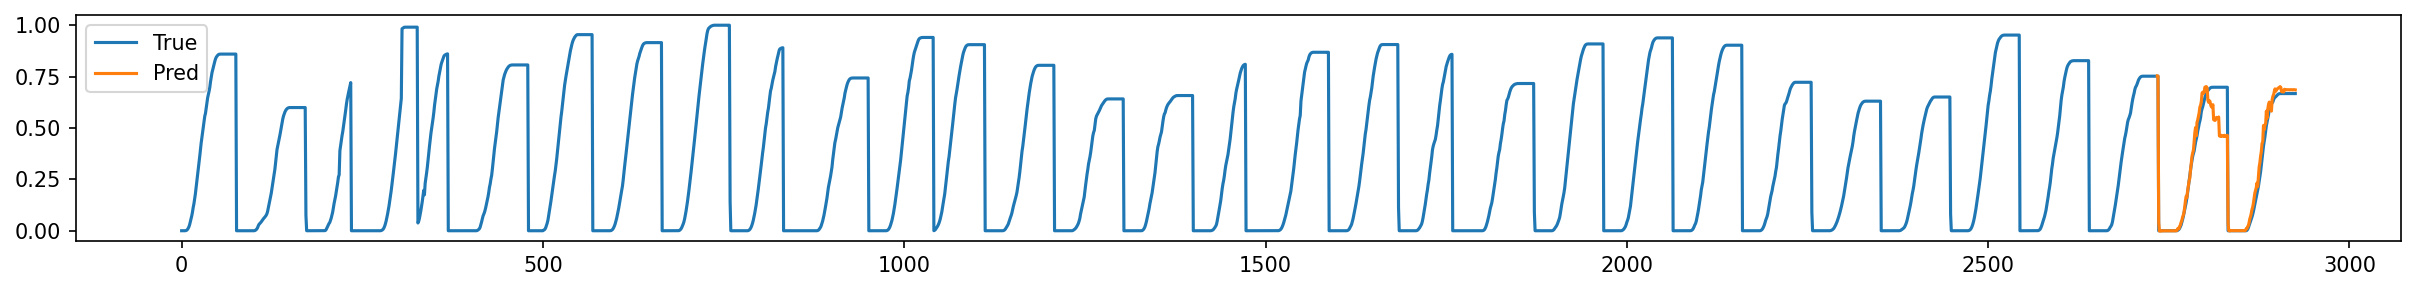

In [9]:
prediction = pd.DataFrame(pred, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,2), dpi=150)

plt.plot(data['DAILY_YIELD'], label = 'True')
plt.plot(prediction, label = 'Pred')

plt.legend()

plt.show()

# Interpretation of XGBoost

In [10]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [11]:
# The training set is evenly divided into 11 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 10
interp_x= x_train
model = model

ShapTime_xgb = ShapleyValues(model, interp_x, Tn)

In [12]:
ShapTime_xgb

[-0.029002991101722594,
 0.011189027993287831,
 0.021932521490972003,
 0.0084836625538513,
 -0.010949970630243581,
 -0.02163021183124403,
 -0.011219129946124107,
 0.026821139138827575,
 -0.012562248757996972,
 0.017491881784238897]

In [13]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

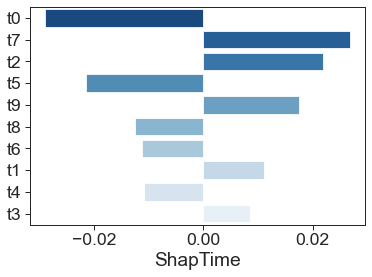

In [14]:
TimeImportance(Tn, ShapTime_xgb, time_columns)

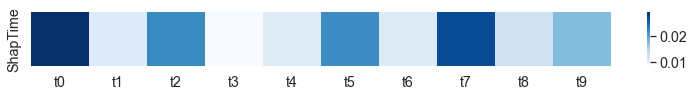

In [15]:
TimeHeatmap(Tn, ShapTime_xgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [53]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [54]:
n = 4
Tn = 10
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_xgb
model = xgboost.XGBRegressor()

In [55]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

In [56]:
result

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,-0.029003,0.011189,0.021933,0.008484,-0.010950,-0.021630,-0.011219,0.026821,-0.012562,0.017492
1,-0.029043,0.011261,0.021955,0.008467,-0.010966,-0.021633,-0.011238,0.026856,-0.012627,0.017521
2,-0.029034,0.011247,0.021940,0.008515,-0.010998,-0.021594,-0.011282,0.026850,-0.012604,0.017515
3,-0.029065,0.011231,0.021935,0.008531,-0.010962,-0.021645,-0.011246,0.026865,-0.012615,0.017526
4,-0.029065,0.011231,0.021935,0.008531,-0.010962,-0.021645,-0.011246,0.026865,-0.012615,0.017526


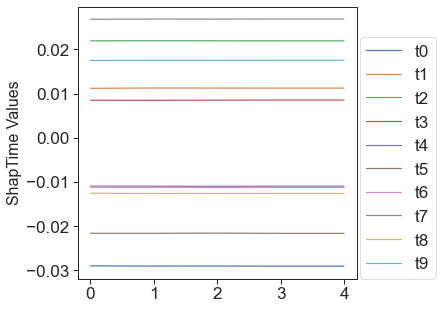

In [57]:
PlotVal(result)

### Sensitivity

In [16]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
situation_1 = [3, 1, 2, 3, 4, 5, 6, 7, 8, 9]
situation_2 = [3, 1, 2, 3, 4, 5, 6, 3, 8, 9]

In [17]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'DATE_TIME')
df_eva = supertime(10, train_eva)
model_eva = xgboost.XGBRegressor()

In [18]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [19]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'DAILY_YIELD', model_eva, total)

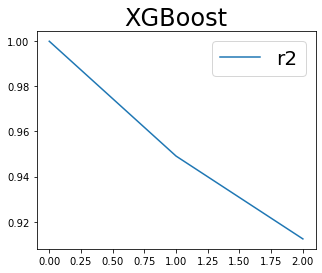

In [20]:
R2Plot(r2_results, 'XGBoost')

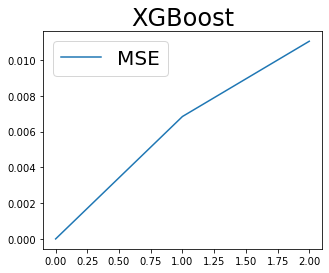

In [21]:
MSEPlot(mse_results, 'XGBoost')

# Improvement

In [17]:
train.shape

(2734, 10)

In [18]:
x_train.shape

(2734, 8)

In [16]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [65]:
check_replist = [t0, t1, t2, t0, t4, t5, t6, t7, t8, t9]

In [66]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_check = check.loc[:, ['DAILY_YIELD']]

model_check = xgboost.XGBRegressor().fit(x_check, y_check)

pred_check = model_check.predict(x_test)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

0.9521062152866216 Degree of Improvement: 2.29%
0.003851689801429236 Degree of Improvement: 30.78%


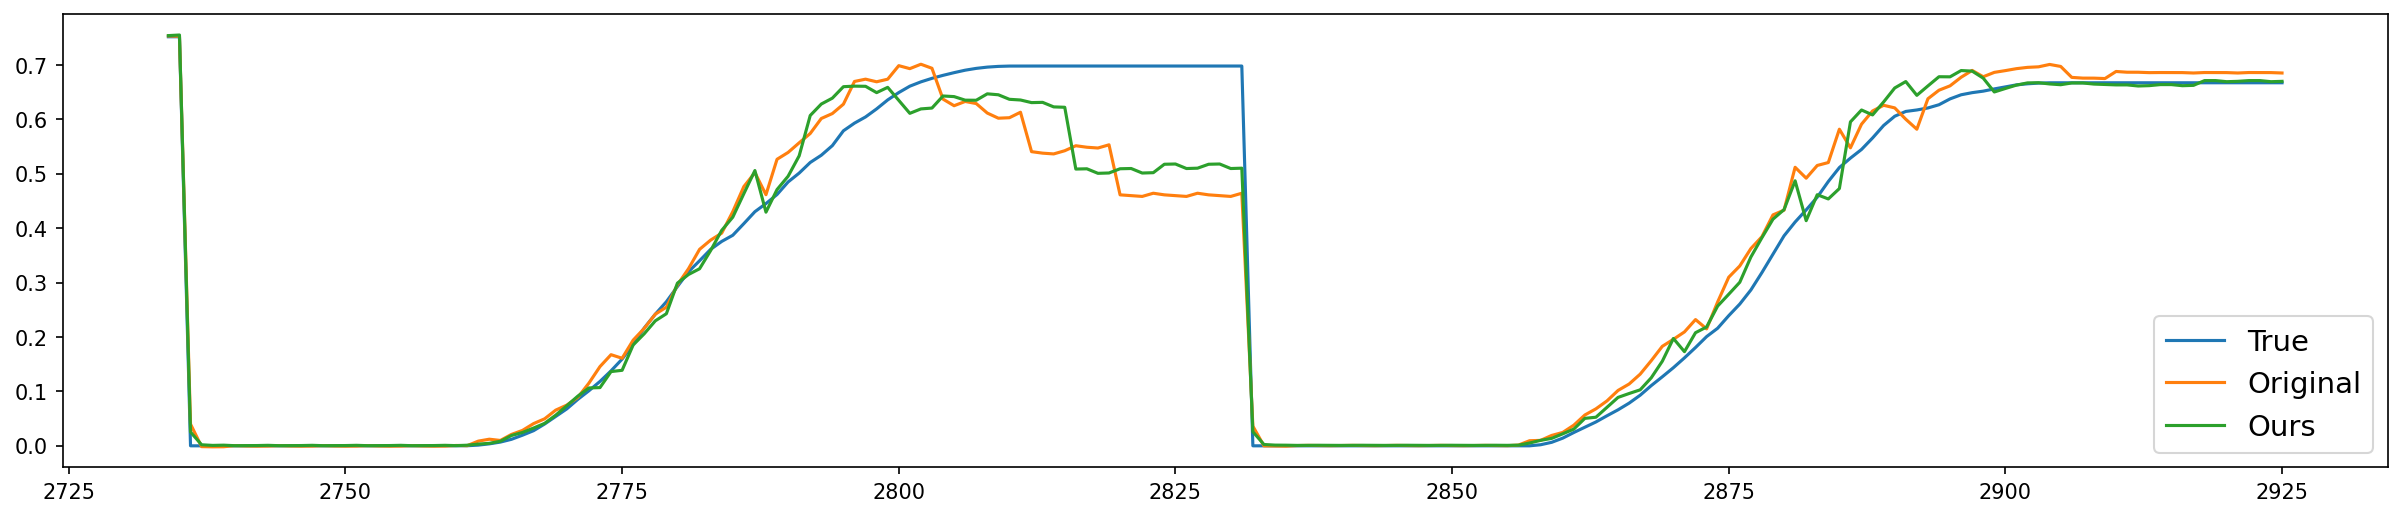

In [67]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['DAILY_YIELD'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()